# Input-Output Graph Centrality

_And so we all matter - maybe less then a lot but always more than none_ - John Green 

Input-output analysis in economics models the interdependencies between sectors by tracking the flow of goods and services. Graph centrality measures are valuable tools for analyzing the structure and dynamics of such networks. By representing input-output data published by the Bureau of Economic Analysis (BEA) as a directed graph (with sectors as nodes and transactions as edges from producers to consumers), we can apply centrality metrics to identify the most influential sectors driving overall economic activity.

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import pandas as pd
from pandas import DataFrame, Series
import networkx as nx
from finds.database import RedisDB
from finds.readers import BEA
from finds.recipes import graph_info, graph_draw
from secret import credentials
# %matplotlib qt
VERBOSE = 0
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 200)

In [2]:
rdb = RedisDB(**credentials['redis'])
bea = BEA(rdb, **credentials['bea'], verbose=VERBOSE)
years = [1947, 2023]
vintages = [1997, 1963, 1947]   # when sectoring schemes were revised
vintage = min(vintages)

## Centrality measures

Graph centrality measures help quantify the importance of nodes within a network, providing insight into their roles and influence.

- **Degree Centrality** measures the number of edges connected to a node, indicating its direct level of activity.
- **Betweenness Centrality** quantifies the extent to which a node lies on the shortest paths between other nodes, capturing its role in network connectivity.
- **Closeness Centrality** assesses how close a node is to all other nodes based on shortest path distances, highlighting its accessibility.
- **Eigenvector Centrality** evaluates a node’s importance based on the centrality of its neighbors, giving higher scores to nodes connected to other influential nodes.
- **PageRank Centrality** was originally developed to rank web pages and operates as a random walk process, estimating the long-term likelihood of visiting each node by following edges.
- **Hubs** are nodes with many outgoing edges, acting as facilitators of flow to other parts of the network.
- **Authorities** are nodes with many incoming edges, representing highly influential entities that are frequently referenced by other nodes.

In [3]:
# Helper to compute centrality measures
def nodes_centrality(G, weight='weight', cost=False, alpha=0.99):
    """Return dict of vertex centrality measures                                     
                                                                                     
    Args:                                                                            
        G: Graph may be directed or indirected, weighted or unweighted               
        weight: name of edge attribute for weights, Set to None for unweighted       
        cost: If True, then weights are costs; else weights are importances          
    """
    out = {}
    # Degree centrality, for directed and undirected graphs
    if nx.is_directed(G):
        out['in_degree'] = nx.in_degree_centrality(G)
        out['out_degree'] = nx.out_degree_centrality(G)
    else:
        out['degree'] = nx.degree_centrality(G)

    # Hubs and Authorities
    out['hub'], out['authority'] = nx.hits(G)

    # if weights are costs, then Eigenvector and Pagerank ignore weights 
    if not cost and nx.is_weighted(G):
        out['eigenvector'] = nx.eigenvector_centrality(G, weight=weight, max_iter=1000)
        out['pagerank'] = nx.pagerank(G, weight=weight, alpha=alpha)
    else:
        out['eigenvector'] = nx.eigenvector_centrality(G, max_iter=1000)
        out['pagerank'] = nx.pagerank(G, alpha=alpha)

    # if weights are importances, then Betweeness and Closeness ignore weights 
    if cost and nx.is_weighted(G):
        out['betweenness'] = nx.betweenness_centrality(G, weight=weight)
        out['closeness'] = nx.closeness_centrality(G, distance=weight)
    else:
        out['betweenness'] = nx.betweenness_centrality(G)
        out['closeness'] = nx.closeness_centrality(G)
    return out


## BEA Input-Output Use Tables


Input-output analysis is an economic modeling technique used to study interdependencies among different sectors. It involves constructing input-output tables that track the flow of goods and services between industries, quantifying how changes in one sector impact others. 



In [4]:
# Read IOUse tables from BEA website
ioUses = {year: bea.read_ioUse(year=year, vintage=vintage) for year in years}

To analyze these relationships, we construct a directed graph from the latest BEA input-output flows, where edges flow from user sectors to make sectors. This allows us to visualize sectoral interactions and determine the most influential industries.

In [5]:
## Direction of edges point from user industry to maker, i.e. follows the money
tail = 'colcode'   # edges follow flow of payments, from column to row
head = 'rowcode'   
drop = ('F','T','U','V','Other')  # drop these codes

# Display node centrality measures from latest year
ioUse = ioUses[max(years)]
data = ioUse[(~ioUse['rowcode'].str.startswith(drop) &
              ~ioUse['colcode'].str.startswith(drop))].copy()

# extract cross data; generate and load edges (as tuples) to graph
data = data[(data['colcode'] != data['rowcode'])]
data['weights'] = data['datavalue'] / data['datavalue'].sum()
edges = data.loc[data['weights'] > 0, [tail, head, 'weights']].values.tolist()
G = nx.DiGraph()
G.add_weighted_edges_from(edges, weight='weight')

# Display graph properties
Series(graph_info(G)).rename('Properties').to_frame()

,Properties
transitivity,0.903811
average_clustering,0.849259
weakly_connected,True
weakly_connected_components,1
size_largest_weak_component,47
strongly_connected,False
strongly_connected_components,4
size_largest_strong_component,44
directed,True
weighted,True


Vizualise graphs of input-output flows for the earliest and latest years available, highlighting the top five sectors with the highest PageRank centrality scores.

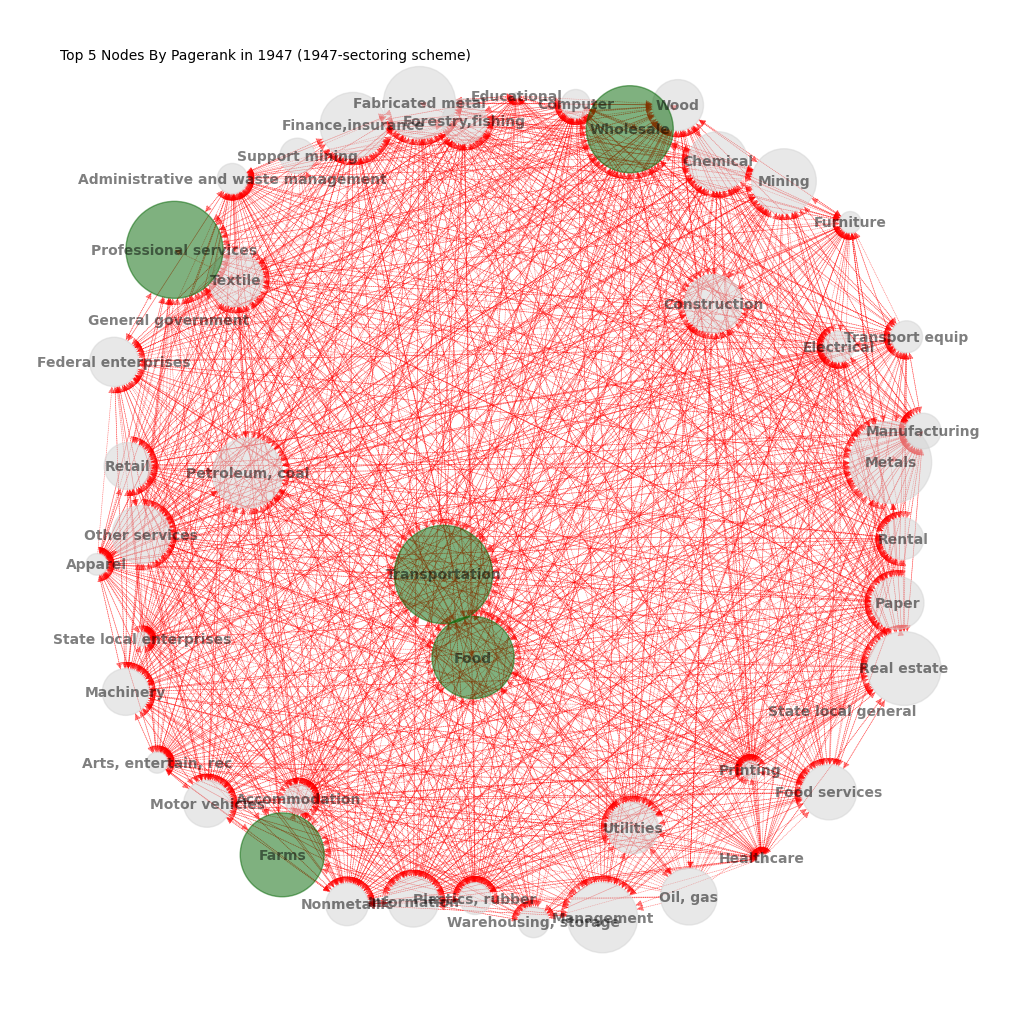

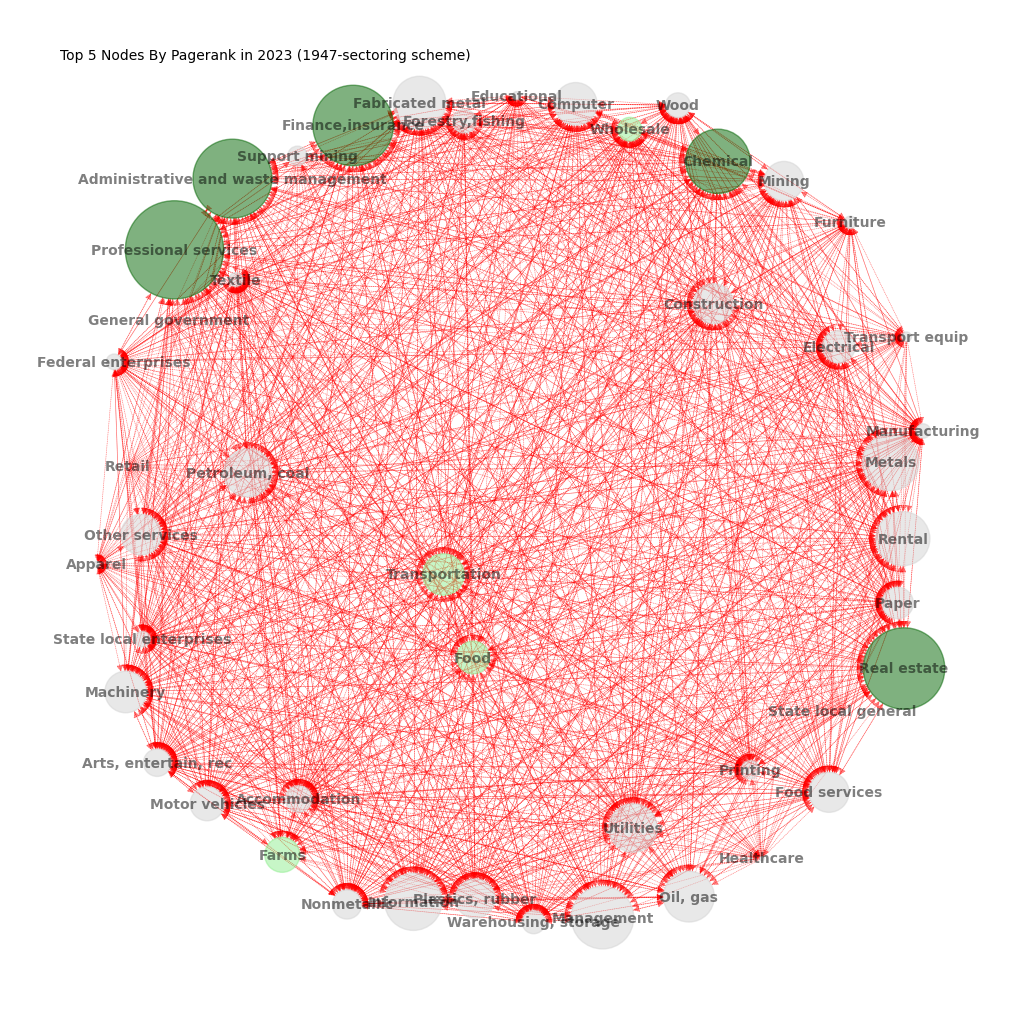

In [9]:
colors = ['lightgrey', 'darkgreen', 'lightgreen']    

# Populate and plot graph of first and last table years
for ifig, year in enumerate(years):
    # keep year, drop invalid rows
    ioUse = ioUses[year]
    data = ioUse[(~ioUse['rowcode'].str.startswith(drop) &
                  ~ioUse['colcode'].str.startswith(drop))].copy()

    # create master table of industries and measurements
    master = data[data['rowcode'] == data['colcode']][['rowcode','datavalue']]\
        .set_index('rowcode')\
        .rename(columns={'datavalue': 'self'})
    
    # extract cross data; generate and load edges (as tuples) to graph
    data = data[(data['colcode'] != data['rowcode'])]
    data['weights'] = data['datavalue'] / data['datavalue'].sum()
    edges = data.loc[data['weights'] > 0, [tail, head, 'weights']]\
                .values\
                .tolist()
    
    G = nx.DiGraph()
    G.add_weighted_edges_from(edges, weight='weight')
    nx_labels = BEA.short_desc[list(G.nodes)].to_dict()

    # update master table industry flow values
    master = master.join(data.groupby(['colcode'])['datavalue'].sum(), how='outer')\
                   .rename(columns={'datavalue': 'user'})
    master = master.join(data.groupby(['rowcode'])['datavalue'].sum(), how='outer')\
                   .rename(columns={'datavalue': 'maker'})
    master = master.fillna(0).astype(int)
    
    # inweight~supply~authority~eigenvector~pagerank, outweight~demand~hub
    centrality = DataFrame(nodes_centrality(G))   # compute centrality metrics
    master = master.join(centrality, how='left')
    master['bea'] = BEA.short_desc[master.index].to_list()

    # visualize graph
    score = centrality['pagerank']
    node_size = score.to_dict()
    node_color = {node: colors[0] for node in G.nodes()}
    if ifig == 0:
        center_name = score.index[score.argmax()]
    else:
        node_color.update({k: colors[2] for k in top_color})
    top_color = list(score.index[score.argsort()[-5:]])
    node_color.update(dict.fromkeys(top_color, colors[1]))
    pos = graph_draw(G,
                     num=ifig+1,
                     figsize=(10, 10),
                     center_name=center_name,
                     node_color=node_color,
                     node_size=node_size,
                     edge_color='r',
                     k=3,
                     pos=(pos if ifig else None),
                     font_size=10,
                     font_weight='semibold',
                     labels=master['bea'].to_dict(),
                     title=f"Top 5 Nodes By Pagerank in {year} ({vintage}-sectoring scheme)")

Display centrality scores for all BEA sectors based on the latest year’s input-output data:

In [7]:
# show industry flow values and graph centrality measures
master = pd.concat(
    (data[data['rowcode'] == data['colcode']][['rowcode', 'datavalue']]\
     .set_index('rowcode')\
     .rename(columns={'datavalue': 'self'}),
     data.groupby(['colcode'])['datavalue'].sum().rename('user'),
     data.groupby(['rowcode'])['datavalue'].sum().rename('maker')),
    join='outer', axis=1).fillna(0).astype(int)
master = master.join(DataFrame(nodes_centrality(G)), how='left')
master['bea'] = BEA.short_desc[master.index].to_list()

print(f"Node Centrality of BEA Input-Output Use Table {year}")
master.drop(columns=['self']).round(3)


Node Centrality of BEA Input-Output Use Table 2023


,user,maker,in_degree,out_degree,hub,authority,eigenvector,pagerank,betweenness,closeness,bea
111CA,183083,413260,0.478,0.783,0.005,0.008,0.039,0.015,0.001,0.657,Farms
113FF,4764,83642,0.543,0.652,0.000,0.001,0.007,0.007,0.001,0.687,"Forestry,fishing"
211,189659,491570,0.674,0.674,0.008,0.004,0.072,0.032,0.004,0.754,"Oil, gas"
212,43330,125323,0.870,0.804,0.002,0.003,0.019,0.019,0.008,0.885,Mining
213,29107,23233,0.087,0.652,0.002,0.000,0.003,0.005,0.000,0.523,Support mining
22,148366,426549,1.000,0.717,0.008,0.026,0.085,0.029,0.002,1.000,Utilities
23,1108514,381314,1.000,0.761,0.037,0.027,0.111,0.020,0.004,1.000,Construction
311FT,610392,378716,0.630,0.804,0.013,0.022,0.039,0.013,0.002,0.730,Food
313TT,22726,46617,0.848,0.761,0.001,0.002,0.004,0.002,0.002,0.868,Textile
315AL,9831,7442,0.435,0.674,0.000,0.000,0.001,0.000,0.000,0.639,Apparel


Compare the 1947 and 1997 sectoring schemes to examine how BEA's industry groupings have evolved over time.

In [8]:
# Compare 1947 and 1997 sector schemes (BEA "summary"-level industry groups)
v1947 = BEA.sectoring(1947).rename(columns={'description': '1947'})
v1997 = BEA.sectoring(1997).rename(columns={'description': '1997'})
df = v1947[['title', '1947']].join(v1997['1997'])
df[df['1947'] != df['1997']]  # changes in the sectoring scheme

,title,1947,1997
code,,,
441000,Motor vehicle and parts dealers,RETAIL TRADE,Motor vehicle and parts dealers
442000,All other retail,RETAIL TRADE,Other retail
443000,All other retail,RETAIL TRADE,Other retail
444000,Building material and garden equipment and supplies dealers,RETAIL TRADE,Other retail
445000,Food and beverage stores,RETAIL TRADE,Food and beverage stores
446000,Health and personal care stores,RETAIL TRADE,Other retail
447000,Gasoline stations,RETAIL TRADE,Other retail
448000,Clothing and clothing accessories stores,RETAIL TRADE,Other retail
451000,All other retail,RETAIL TRADE,Other retail


__References:__

Jason Choi & Andrew T. Foerster, 2017. "The Changing Input-Output Network Structure of the U.S. Economy," Economic Review, Federal Reserve Bank of Kansas City, issue Q II, pages 23-49

https://www.bea.gov/industry/input-output-accounts-data

https://www.bea.gov/information-updates-national-economic-accounts